## Reaction Optimization

### Descriptor generation

run `smiles2gjf` to generate gjf file from SMILES

In [4]:
from pathlib import Path
import pandas as pd
from utils.smiles2gjf import SeriesSmiles2gjf

reagent_type = "oxidant"
smiles_list = pd.read_csv(Path(f"reaction_space/{reagent_type}.csv"))["SMILES"]
SeriesSmiles2gjf(
    smiles_list,
    destination_path=Path(f"Gauss_Calcs/{reagent_type}"),
    command="#p b3lyp def2svp opt freq",
    spin=1,
    core_num=24,
    memory=10,
    idx_start=0,
)


   Cc1cc(C)[n+](F)c(C)c1.O=S(=O)([O-])C(F)(F)F
   Cc1cc(C)[n+](F)c(C)c1.FB(F)F.[F-]
   F[n+]1ccccc1.O=S(=O)([O-])C(F)(F)F
   F[B-](F)(F)F.F[B-](F)(F)F.F[N+]12CC[N+](CCl)(CC1)CC2
   O=C(O)c1ccccc1I(=O)=O
   O=Ic1ccccc1
   O=C1OI(O)c2ccccc21
   O=C1CCC(=O)N1Cl
   O=C1c2ccccc2S(=O)(=O)N1Cl
   CC1(C)C(=O)N(Cl)C(=O)N1Cl
   COC(=O)NC(=NCl)NC(=O)OC
   O=C1c2ccccc2C(=O)N1Cl
   O=S(=O)([O-])OOS(=O)(=O)[O-].[K+].[K+]
   O=S(=O)(O)O.O=S(=O)(O)O.O=S(=O)(O)O[O-].[K+]
   O=[N+]([O-])[O-].O=[N+]([O-])[O-].O=[N+]([O-])[O-].O=[N+]([O-])[O-].O=[N+]([O-])[O-].O=[N+]([O-])[O-].[Ce+4].[NH4+].[NH4+]
   F[B-](F)(F)F.[Ag+]


[20:48:52] UFFTYPER: Unrecognized charge state for atom: 0
[20:48:52] UFFTYPER: Unrecognized atom type: Ce+3 (0)
[20:48:52] UFFTYPER: Unrecognized atom type: Ag5+1 (0)


Conduct a Gaussian calculation using **g16**.

- Some of the molecular conformations should be manually adjusted to achieve a proper conformation.
- All the intermediate `.chk` files should be preserved.

After the calculation is completed, all results should be checked to prevent errors (such as virtual frequencies or SCF not converging). 

Then, all the binary `.chk` files should be converted to text `.fchk` files using the `formchk` command.

Finally, use Multiwfn 3.8-dev to generate descriptors.

NOTE: 

1. The execution path for Multiwfn should be specified in the `wfnDescGet/wfn_desc_get.py` file.
2. The execution path for Gaussian should be specified in the `setting.ini` file of Multiwfn using the `gaupath=...` parameter.

In [1]:
from pathlib import Path
import subprocess
import pandas as pd
from wfnDescGet.wfn_desc_get import get_all_wfn_descriptors


# You may need to explicitly load the GAUSS_EXEDIR environment variable, which can be checked with `echo $GAUSS_EXEDIR`
import os
os.environ["GAUSS_EXEDIR"] = "/usr/local/bin/g16/bsd:/usr/local/bin/g16"

mol_type = "oxidant"
folder_type = "oxidant"
data_df = pd.read_csv(f"index_info/{mol_type}.csv")
fchk_files = Path(f"Gauss_Calcs_origin/{folder_type}/output_fchk").glob("*.fchk")
# atoms_list = data_df["atoms_list"]
# bond_list = [[0, 1], [1, 2], [2, 3]]
# angle_list = [[0, 1, 2], [1, 2, 3]]
# dihedral_list = [[0, 1, 2, 3]]
prop = data_df["prop"].tolist()
df = get_all_wfn_descriptors(
    fchk_files=fchk_files,
    # atoms_list=atoms_list,
    # bond_list=bond_list,
    # angle_list=angle_list,
    # dihedral_list=dihedral_list,
    calc_method="b3lyp/def2svp",
    prop=prop,
    kill=True,
    file_mode=1,
    fchk_files_sort=True,
)
df.to_csv(f"{mol_type}_desc_datadf.csv")


-----< Now generate CDFT descriptors >-----


10it [09:36, 57.69s/it]


-----< Now generate ESP descriptors >-----


10it [00:54,  5.49s/it]


-----< Now generate molecular shape descriptors >-----


10it [00:21,  2.19s/it]


-----< Now generate orbit descriptors >-----


10it [00:00, 11.41it/s]


### Reaction Optimization

Prepare the descriptor file corresponding to the reaction space and construct the reaction space.

1. generate starting points of experimental space.

In [2]:
from datetime import datetime
import pandas as pd
from pathlib import Path
from rdkit import Chem

from summit.domain import CategoricalVariable, ContinuousVariable
from summit import Domain
from summit.utils.dataset import DataSet

from condition_opt.EDBOplus.edbo import newEDBO
from condition_opt.utils import descClass, get_reaction_space, get_target_value, canonicalize_smiles


bayesian_opt_round = 'test' # selecting bayesian optimization round
data_path = f"condition_opt"
batch_size = 5 # number of experiments to suggest

exp_datapath = data_path / Path(f"opt_round_{bayesian_opt_round}/manual_conditions_new.csv")

# generate reaction space
reagent_types = ["amine", "cobalt", "oxidant", "alkali", "solvent"]
desc_class = descClass(Path("descriptors"))
domain = Domain()
domain = get_reaction_space(domain, desc_class, reagent_types=reagent_types)

# generate target columns
domain = get_target_value(domain)

new_batch_id = 0
# proceed EDBO
print("Beginning EDBO initialization...")
edbo = newEDBO(domain=domain, seed=42, init_sampling_method="CVT")
print("Beginning New reaction suggestion...")
edbo_restults = edbo.suggest_experiments(batch_size=batch_size) # generate new experiments

# save results
formatted_date = datetime.now().strftime("%Y%m%d")  # get data with format 'yyyymmdd'
edbo_restults.to_csv(data_path / Path(f"opt_round_{bayesian_opt_round}/edbo-results_batch-{new_batch_id}_{formatted_date}.csv"))


Total Reaction Space Size: 114400
Beginning EDBO initialization...


100%|██████████| 114400/114400 [02:23<00:00, 798.51it/s]


Beginning New reaction suggestion...
Sampling type:  selection 


Number of unique samples returned by sampling algorithm: 2


/home/alchemy/anaconda3/envs/react_opt/lib/python3.10/site-packages/idaes/surrogate/pysmo/sampling.py:172: UserWarning: The returned number of samples is less than the requested number due to repetitions during nearest neighbour selection.
  warnings.warn(


After completing the initial experiments, the experimental results will be organized and saved in `manual_conditions_new.csv` as follows:
```csv
batch_id,amine_smiles,cobalt_smiles,oxidant_smiles,alkali_smiles,solvent_smiles,yield,ee,select_tag
0,amine_SMILES_1,cobalt_CODE_1,oxidant_SMILES_1,additive_SMILES_1,solvent_SMILES_1,0,0,TRUE
0,amine_SMILES_2,cobalt_CODE_2,oxidant_SMILES_2,additive_SMILES_2,solvent_SMILES_2,0,0,TRUE
0,amine_SMILES_3,cobalt_CODE_3,oxidant_SMILES_3,additive_SMILES_3,solvent_SMILES_3,31,87,TRUE
0,amine_SMILES_4,cobalt_CODE_4,oxidant_SMILES_4,additive_SMILES_4,solvent_SMILES_4,27,72,TRUE
0,amine_SMILES_5,cobalt_CODE_5,oxidant_SMILES_5,additive_SMILES_5,solvent_SMILES_5,25,60,TRUE
```
You will also set the `batch_size` to specify the number of experiments to recommend each time. 

The newly recommended reactions will be saved in files with the format `edbo-results_batch-i-<date>.csv`.


In [1]:
from datetime import datetime
import pandas as pd
from pathlib import Path
from rdkit import Chem

from summit.domain import CategoricalVariable, ContinuousVariable
from summit import Domain
from summit.utils.dataset import DataSet

from condition_opt.EDBOplus.edbo import newEDBO
from condition_opt.utils import descClass, get_reaction_space, get_target_value, canonicalize_smiles


bayesian_opt_round = 'test' # selecting bayesian optimization round
data_path = f"condition_opt"
batch_size = 5 # number of experiments to suggest

exp_datapath = data_path / Path(f"opt_round_{bayesian_opt_round}/manual_conditions_new.csv")

# generate reaction space
reagent_types = ["amine", "cobalt", "oxidant", "alkali", "solvent"]
desc_class = descClass(Path("descriptors"))
domain = Domain()
domain = get_reaction_space(domain, desc_class, reagent_types=reagent_types)

# generate target columns
domain = get_target_value(domain)

data_df = pd.read_csv(exp_datapath)
data_df = data_df[data_df["select_tag"] == True]
new_batch_id = data_df["batch_id"].max() + 1

# canonicalize smiles in data_df except for cobalt.
for tp in reagent_types:
    if tp != "cobalt":
        data_df[f"{tp}_smiles"] = data_df[f"{tp}_smiles"].apply(canonicalize_smiles)

# process for done experments datas
done_dataset = data_df.iloc[:, 1:]
done_dataset.columns = reagent_types + ["yld", "ee", "select_tag"]

# check if all batch molecules in reaction space
desc_dict = desc_class.get_desc_df()

done_dataset.reset_index(inplace=True, drop=True)
for i in done_dataset.index:
    for tp in reagent_types:
        if done_dataset.loc[i, tp] not in desc_dict[tp].index:
            print(f"Invalid {tp} molecule: {done_dataset.loc[i, tp]}")
            done_dataset.loc[i, "select_tag"] = False

print(done_dataset["select_tag"].value_counts())
done_dataset = done_dataset[done_dataset["select_tag"]]
done_dataset = done_dataset.drop(columns=["select_tag"])

done_dataset.reset_index(inplace=True)
done_dataset = DataSet.from_df(done_dataset)

# proceed EDBO
print("Beginning EDBO initialization...")
edbo = newEDBO(domain=domain, seed=42, init_sampling_method="CVT")
print("Beginning New reaction suggestion...")
edbo_restults = edbo.suggest_experiments_new(prev_res=done_dataset, batch_size=5)
# edbo_restults = edbo.suggest_experiments(prev_res=done_dataset, batch_size=5)

# save results
formatted_date = datetime.now().strftime("%Y%m%d")  # get data with format 'yyyymmdd'
edbo_restults.to_csv(data_path / Path(f"opt_round_{bayesian_opt_round}/edbo-results_batch-{new_batch_id}_{formatted_date}.csv"))


Total Reaction Space Size: 114400
True    5
Name: select_tag, dtype: int64
Beginning EDBO initialization...


100%|██████████| 114400/114400 [02:27<00:00, 773.79it/s]


Beginning New reaction suggestion...
build and optimize model for a variable.


/home/alchemy/AIChem/Ether_Reaction_Github/condition_opt/EDBOplus/pareto.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.Tensor(ans_points)
100%|██████████| 1000/1000 [00:03<00:00, 265.56it/s]
/home/alchemy/anaconda3/envs/react_opt/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


build and optimize model for a variable.


100%|██████████| 1000/1000 [00:03<00:00, 287.60it/s]
/home/alchemy/AIChem/Ether_Reaction_Github/condition_opt/EDBOplus/edbo.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y=torch.tensor(pareto_y).float()


## Scope Exploration of Alcohols

### Alcohol candidates collection

Collect commercially available types of alcohols from reagent suppliers and clean them to ensure they meet reaction requirements

In [5]:
from reduction_clustering.data_clean import alcohol_cleaning

alcohol_cleaning(strict_mode=True)

checking data1...


[10:27:59] WARNING: not removing hydrogen atom without neighbors
[10:27:59] WARNING: not removing hydrogen atom without neighbors
[10:27:59] WARNING: not removing hydrogen atom without neighbors
[10:27:59] WARNING: not removing hydrogen atom without neighbors
[10:27:59] WARNING: not removing hydrogen atom without neighbors
[10:27:59] WARNING: not removing hydrogen atom without neighbors
[10:27:59] WARNING: not removing hydrogen atom without neighbors
[10:27:59] WARNING: not removing hydrogen atom without neighbors
[10:27:59] WARNING: not removing hydrogen atom without neighbors
[10:27:59] WARNING: not removing hydrogen atom without neighbors
[10:27:59] WARNING: not removing hydrogen atom without neighbors
[10:27:59] WARNING: not removing hydrogen atom without neighbors
[10:27:59] WARNING: not removing hydrogen atom without neighbors
[10:27:59] WARNING: not removing hydrogen atom without neighbors
[10:27:59] WARNING: not removing hydrogen atom without neighbors
[10:27:59] WARNING: not r

checking data2...
checking data3...
Before basic data clean, len of smiles: 8280
After basic data clean, len of smiles: 7954
After canonical, len of smiles: 6854
After alcohol check, length of smiles: 6832.
After multi OH check, length of smiles: 5217.
After removing nucleo atoms, length of smiles: 2434.
After removing too difficult alcohol, length of smiles: 2433.


,Smiles,Tag,OH_level,O_index,Exp_State
0,CC(C)(C)OC(=O)N1CCC(CO)C1,True,1,12,No_Exp
1,Oc1ccncc1,True,2,0,No_React
2,C#CC1(O)CCCCC1,True,3,3,No_Exp
3,O=C1CC[C@@H](CO)N1,True,1,6,No_Exp
6,CC(C)c1cccc(=O)c(O)c1,True,2,10,No_Exp
...,...,...,...,...,...
8234,OC1CCCCCCCCCCCCCC1,True,2,0,React
8239,C#CCO,True,1,3,React
8244,C/C(=C\CO)CCC[C@H](C)CCC[C@H](C)CCCC(C)C,True,1,4,React
8252,Cc1ccc(S(=O)(=O)OCCO)cc1,True,1,11,No_React


### Alcohol reduction and clustering

Alcohol descriptors are generated by [HSPOC](https://github.com/DeepSynthesis/HSPOC/) with the reactive O atom as the reaction center.

using UMAP for dimension reduction and K-Means for alcohol clustering

In [8]:
from pathlib import Path
from reduction_clustering.reduction_clustering import get_cluster_and_reduction_results
import pandas as pd

reduction_type = "alcohol"

input_csv = Path(f"reduction_clustering/data/all_{reduction_type}_in_strict_mode.csv")  # csv file path
smiles_column = "SMILES"  
recalc_desc = False
set_level = 0
draw_pictures = True
n_clusters = 6
decomp_name = "UMAP"
cluster_name = "kmeans-with-agglomeration"
n_clusters_determined = "pass"  # elbow, silhouette, pass
opt = False

decomp_data = get_cluster_and_reduction_results(
    input_csv=input_csv,
    smiles_column=smiles_column,
    reduction_type=reduction_type,
    set_level=set_level,
    n_clusters=n_clusters,
    decomp_name=decomp_name,
    cluster_name=cluster_name,
    n_clusters_determined=n_clusters_determined,
    recalc_desc=recalc_desc,
)

decomp_data

2025-02-08 10:31:43.452 | INFO     | reduction_clustering.reduction_clustering:get_cluster_and_reduction_results:36 - Data not be calculated: []
2025-02-08 10:31:43.501 | INFO     | reduction_clustering.reduction_clustering:get_cluster_and_reduction_results:61 - (2433, 176)
2025-02-08 10:31:43.502 | INFO     | reduction_clustering.utils:dimension_reduction:99 - Start UMAP decomposition...
2025-02-08 10:31:55.059 | INFO     | reduction_clustering.utils:dimension_reduction:101 - UMAP decomposition done!
2025-02-08 10:31:55.061 | INFO     | reduction_clustering.utils:data_clustering:116 - Start kmeans-with-agglomeration cluster...
2025-02-08 10:31:55.405 | INFO     | reduction_clustering.utils:data_clustering:144 - kmeans-with-agglomeration cluster done!


,SMILES,level,Exp_State,component1,component2,label
0,CC(C)(C)OC(=O)N1CCC(CO)C1,1,No_Exp,4.138629,19.122229,1
1,Oc1ccncc1,2,No_React,1.892678,-7.638937,3
2,C#CC1(O)CCCCC1,3,No_Exp,9.692216,2.279082,2
3,O=C1CC[C@@H](CO)N1,1,No_Exp,14.174717,8.283502,4
4,CC(C)c1cccc(=O)c(O)c1,2,No_Exp,-0.993900,11.458968,1
...,...,...,...,...,...,...
2428,OC1CCCCCCCCCCCCCC1,2,React,14.865329,6.691792,0
2429,C#CCO,1,React,4.416317,17.749357,1
2430,C/C(=C\CO)CCC[C@H](C)CCC[C@H](C)CCCC(C)C,1,React,9.663150,-8.363156,3
2431,Cc1ccc(S(=O)(=O)OCCO)cc1,1,No_React,10.099720,1.797216,2


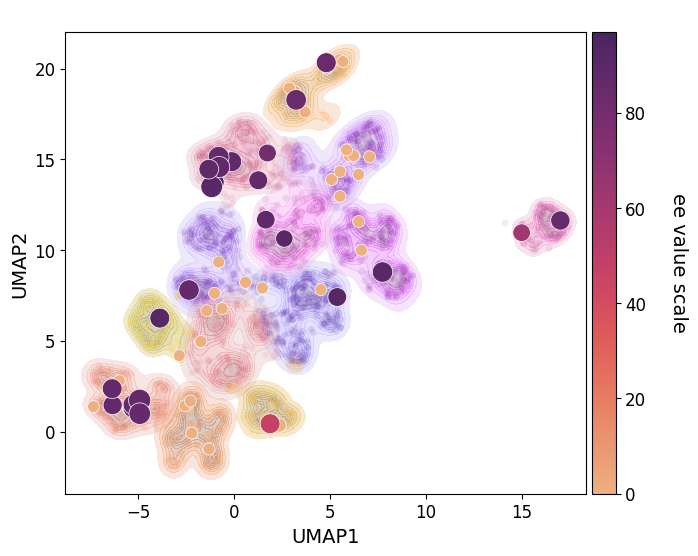

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.colors as mcolors
import seaborn as sns
from rdkit import Chem

level = 0
reduction_type = "alcohol"
input_df = pd.read_csv(f"reduction_clustering/{reduction_type}_results_structure/level_{level}_decomped.csv", index_col=0)
exp_df = pd.read_csv(f"reduction_clustering/data/experimental_data_results_of_{reduction_type}.csv")  #  read experimental data
c_id = 1

unique_labels = input_df["label"].unique()
num_labels = len(unique_labels)

palette = sns.color_palette("plasma", num_labels)
plt.figure(figsize=(8, 6))

unique_labels = sorted(input_df["label"].unique())
for label, scatter_color in zip(unique_labels, palette):
    label_data = input_df[input_df["label"] == label]
    sns.kdeplot(x=label_data["component1"], y=label_data["component2"], fill=True, alpha=0.3, color=scatter_color)

scatter_plot = sns.scatterplot(data=input_df, x="component1", y="component2", hue="label", palette=palette, s=25, alpha=0.1)

exp_df["react_tag"] = (exp_df["condition1_yield"] != 0) | (exp_df["condition2_yield"] != 0)
exp_df["SMILES"] = exp_df["SMILES"].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=True))

merged_df = exp_df.merge(input_df[["alcohol_SMILES", "component1", "component2"]], how="left", left_on="SMILES", right_on="alcohol_SMILES")

exp_df["component1"] = merged_df["component1"]
exp_df["component2"] = merged_df["component2"]

unmatched_smiles = exp_df[exp_df["component1"].isna() | exp_df["component2"].isna()]["SMILES"]

if not unmatched_smiles.empty:
    print("The following smiles were not found in input_df:")
    print(unmatched_smiles.to_list())

norm = mcolors.Normalize(vmin=exp_df[f"condition{c_id}_ee"].min(), vmax=exp_df[f"condition{c_id}_ee"].max())

colorcmap = sns.color_palette("flare", as_cmap=True)
norm = mcolors.Normalize(vmin=exp_df[f"condition{c_id}_ee"].min(), vmax=exp_df[f"condition{c_id}_ee"].max())
exp_df["color"] = exp_df.apply(lambda row: mcolors.to_hex(colorcmap(norm(row[f"condition{c_id}_ee"]))), axis=1)
exp_df["size"] = exp_df.apply(lambda row: 75 if not row["react_tag"] else row[f"condition{c_id}_yield"] * 2 + 100, axis=1)
exp_df = exp_df.iloc[::-1].reset_index(drop=True)
plt.scatter(
    exp_df["component1"],
    exp_df["component2"],
    c=exp_df["color"],
    s=exp_df["size"],
    alpha=1,
    edgecolors="white",
    linewidths=0.5,
)

# Add color bar for condition1_ee
sm = plt.cm.ScalarMappable(cmap=colorcmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.01)
cbar.ax.tick_params(labelsize=12)
cbar.set_label("ee value scale", rotation=270, labelpad=30, fontsize=14)  # Rotate label and adjust padding

plt.xlabel("UMAP1", size=14)
plt.ylabel("UMAP2", size=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend().set_visible(False)
plt.title(" ")

plt.show()
